In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

In [93]:
# Importing Borders frame
dfbord = (
    pd.read_csv('Data/COUNTRY-BORDERS.csv')
    .pipe( 
        lambda _df: _df.assign( 
        country_code = np.where( (_df.country_code.isna()) & (_df.country_name == 'Namibia'), 'NA', _df.country_code ),
        country_border_code = np.where( (_df.country_border_code.isna()) & (_df.country_border_name == 'Namibia'), 'NA', _df.country_border_code )
        #Namibia country code is troublesome, manually fixing it
        )
    .set_index('country_code')
    ))

dfbord.head()

,country_name,country_border_code,country_border_name
country_code,,,
AD,Andorra,FR,France
AD,Andorra,ES,Spain
AE,United Arab Emirates,OM,Oman
AE,United Arab Emirates,SA,Saudi Arabia
AF,Afghanistan,CN,China


In [58]:
# Debug
#dfbord[dfbord["country_name"].str.contains("Namibia")]
#dfbord[dfbord["country_border_name"] == "Namibia"]

In [223]:
# Importing Continental information 
continents = (
    pd.read_csv('Data/world-administrative-boundaries.csv', sep=";", usecols=['ISO 3166-1 Alpha 2-Codes','Continent of the territory'])
    .dropna()
    .rename(columns={'Continent of the territory':'continent', 'ISO 3166-1 Alpha 2-Codes':'CC'})
    .set_index('CC')
    #.to_dict()
    )

# Complementing keys missing:
continents.loc['NA'] = 'Africa'
continents.loc['AQ'] = 'Antarctica'

continents.loc['AX'] = 'Europe'
continents.loc['BL'] = 'America'
continents.loc['BQ'] = 'America'
continents.loc['CW'] = 'America'
continents.loc['GG'] = 'Europe'
continents.loc['GS'] = 'Antarctica'
continents.loc['IM'] = 'Europe'
continents.loc['JE'] = 'Europe'
continents.loc['MF'] = 'America'
continents.loc['PM'] = 'America'
continents.loc['SH'] = 'Africa'
continents.loc['SX'] = 'America'
continents.loc['UM'] = 'Oceania'
continents.loc['WF'] = 'Oceania'

# Dropping duplicates
continents = continents.loc[~continents.index.duplicated()]

In [109]:
# Merging continental info for easy slicing
dfbord = dfbord.merge(continents, left_index=True, right_index=True, how='left')
dfbord

,country_name,country_border_code,country_border_name,continent
AD,Andorra,FR,France,Europe
AD,Andorra,ES,Spain,Europe
AE,United Arab Emirates,OM,Oman,Asia
AE,United Arab Emirates,SA,Saudi Arabia,Asia
AF,Afghanistan,CN,China,Asia
...,...,...,...,...
ZM,Zambia,ZW,Zimbabwe,Africa
ZW,Zimbabwe,BW,Botswana,Africa
ZW,Zimbabwe,MZ,Mozambique,Africa
ZW,Zimbabwe,ZA,South Africa,Africa


In [248]:
color_mapping = {
    'Europe' : '#086b93', # blue-green
    'Asia' : '#FF4848', #pink
    'Africa' : '#FFD371', #yellow-softpeach
    'Americas' : '#C2FFD9', # turquoise
    'Oceania' : '#EE9322', # orange
    'Antarctica' : '#C2C2C2' # gray
    }

# Preparing for graph plot

The best approach to generate a coprehensive plot of the network is to slice continentaly, create a layout from each land mass, save the layouts, fix positions strategically, and then compile it in a single plot.

In [312]:
def circular_layout_isolated_nodes(positions_dict, isolated_nodes, radius = 4, horz_offset = 0, vert_offset = 0):

    angle = 2 * np.pi / len(isolated_nodes)
    for i, node in enumerate(isolated_nodes):
        x = radius * np.cos(i * angle) - horz_offset
        y = radius * np.sin(i * angle) - vert_offset
        positions_dict[node] = (x, y)

    return positions_dict

## Americas

In [190]:
# Americas
amGR = nx.Graph()

# Filtered frame
_CONTINENTS = ['Americas']
fr = dfbord.query("continent.isin(@_CONTINENTS)")

vrtxs = fr.index.unique()
edges = (fr
            .dropna() # islands will not have edges to connect to.
            .pipe(
                lambda _df: 
                    _df.assign( edges = list(zip(_df.index, _df['country_border_code']))) 
            )
            .edges
            .to_list()
            )

amGR.add_nodes_from(vrtxs)
amGR.add_edges_from(edges)

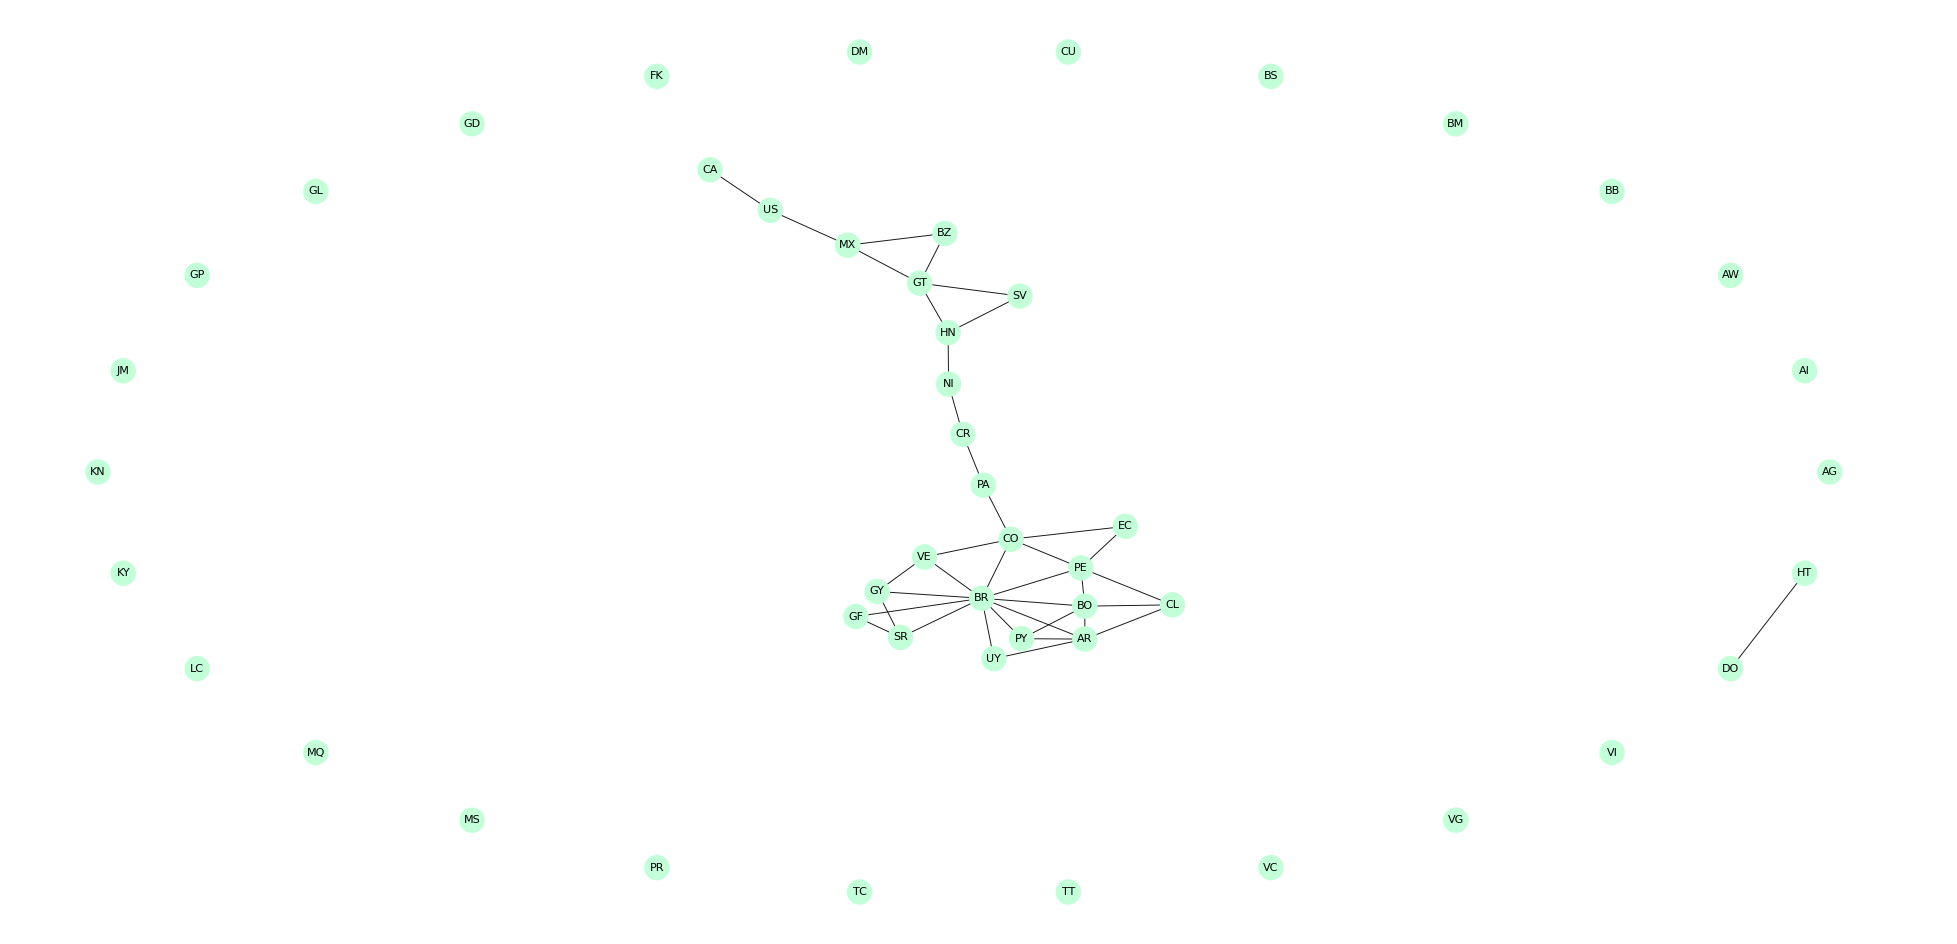

In [191]:
# Identify nodes with no edges (degree 0)
isolated_nodes = [node for node, degree in amGR.degree() if degree == 0]

# To avoid overlay of Dominican Republic and Haiti with continental mass
isolated_nodes.append('DO')
isolated_nodes.append('HT')

# Compute the layout for nodes with edges
amer_pos = nx.kamada_kawai_layout(amGR.subgraph([node for node in amGR if node not in isolated_nodes]), scale=5)

# Plotting isolated nodes
amer_pos = circular_layout_isolated_nodes(amer_pos, isolated_nodes, radius=7)
 
# Getting propper color mapping
COLORS = [ color_mapping[continents.loc[nodes, 'continent']] for nodes in list(amGR.nodes)]

plt.figure(figsize=(25,12))

# Draw nodes 
nx.draw_networkx_nodes(amGR, amer_pos, node_size=300, node_color=COLORS, alpha=1)
# Draw edges
nx.draw_networkx_edges(amGR, amer_pos, width=0.7, alpha=0.9)
# Draw node labels
nx.draw_networkx_labels(amGR, amer_pos, labels={node: node for node in vrtxs}, font_size=8)

sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()

## Europe, Asia, Africa + Antartica

In [370]:
# Americas
LMGR = nx.Graph()

# Filtered frame
_CONTINENTS = ['Europe', 'Asia', 'Africa', 'Oceania', 'Antarctica']
fr = dfbord.query("continent.isin(@_CONTINENTS)")

vrtxs = fr.index.unique()
edges = (fr
            .dropna() # islands will not have edges to connect to.
            .pipe(
                lambda _df: 
                    _df.assign( edges = list(zip(_df.index, _df['country_border_code']))) 
            )
            .edges
            .to_list()
            )

LMGR.add_nodes_from(vrtxs)
LMGR.add_edges_from(edges)

In [371]:
# Identify nodes with no edges (degree 0)
isolated_nodes = [node for node, degree in LMGR.degree() if degree == 0]


# Custom order
order = ['Africa', 'Europe', 'Asia', 'Oceania', 'Antarctica']
ordered_isolated_nodes = (
                        dfbord
                            .loc[isolated_nodes]
                            .pipe( lambda _df: _df.assign( continent = pd.Categorical(_df['continent'], categories=order, ordered=True) ))
                            .sort_values(by='continent')
                        )

oceania_isolated = dfbord.loc[isolated_nodes].query("continent == 'Oceania'").index.to_list()
others_isolated = ordered_isolated_nodes.loc[~ordered_isolated_nodes.index.isin(oceania_isolated)].index.to_list()

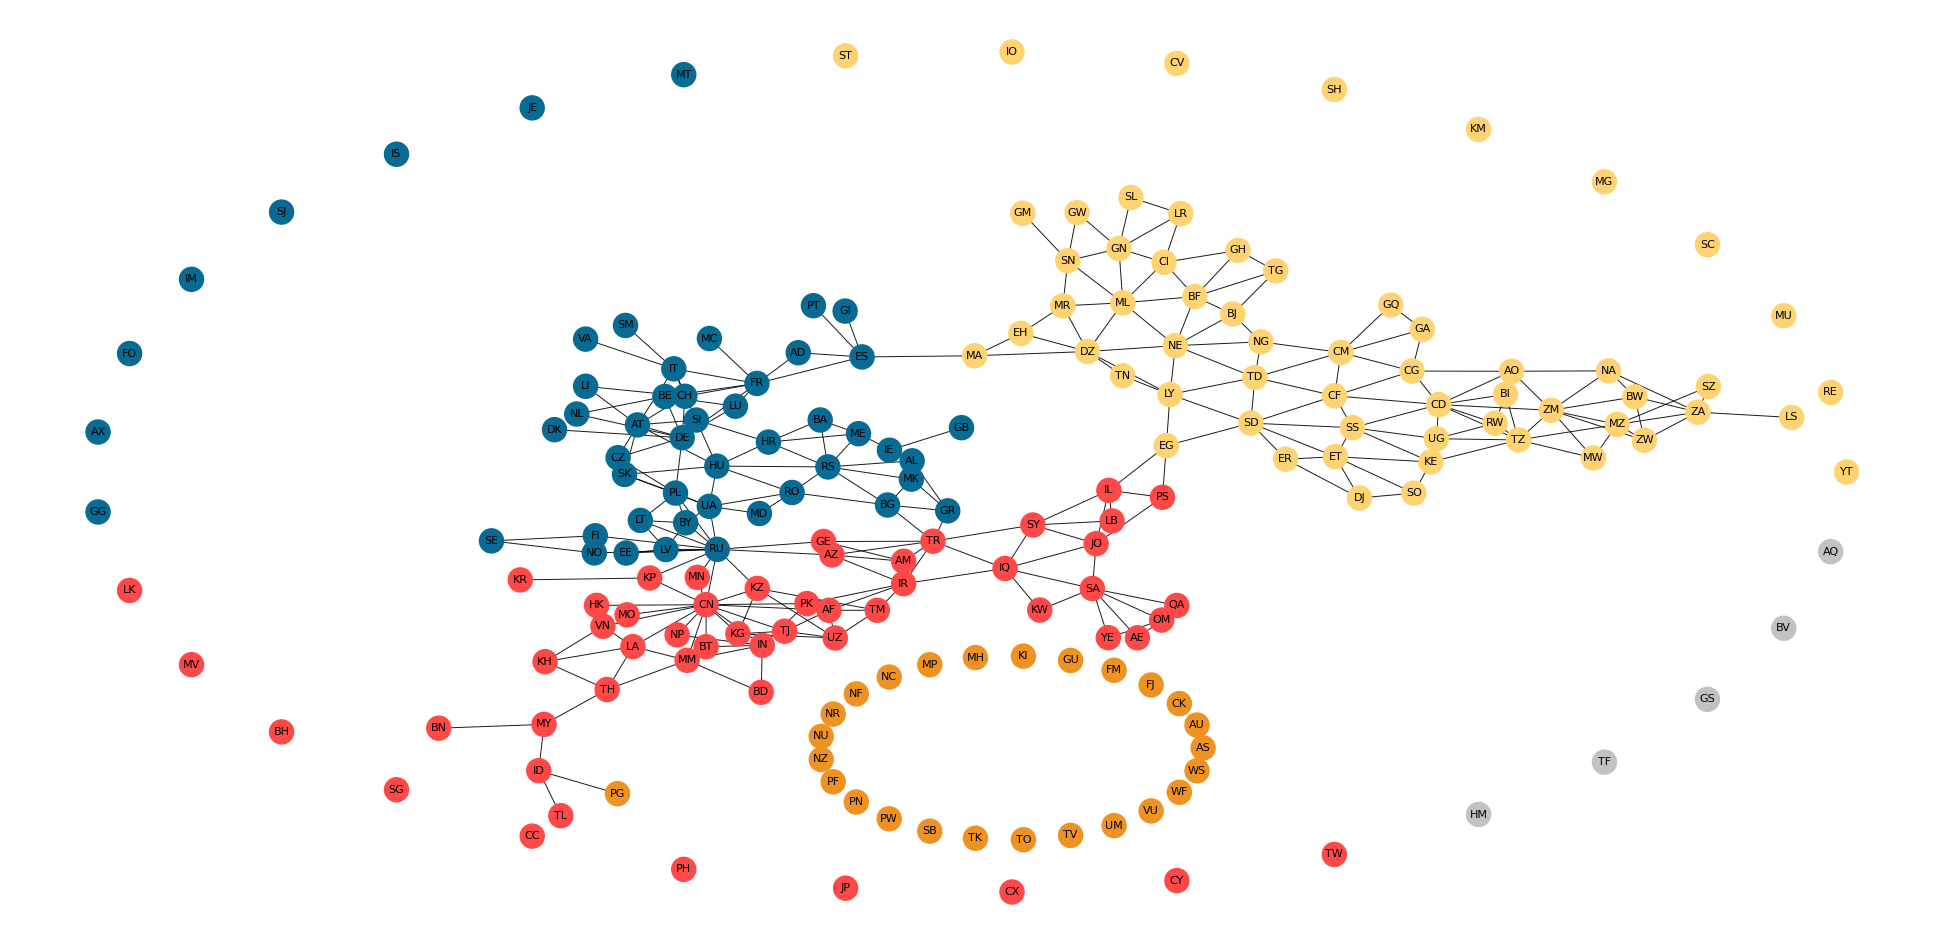

In [372]:
# Compute the layout for nodes with edges
LM_pos = nx.kamada_kawai_layout(LMGR.subgraph([node for node in LMGR if node not in isolated_nodes]), scale=300)
#LM_pos = nx.spring_layout(LMGR.subgraph([node for node in LMGR if node not in isolated_nodes]), k=1)
#nx.spring_layout(GR, k=0.09)

# Plotting not Oceania nodes
LM_pos = circular_layout_isolated_nodes(LM_pos, others_isolated, radius=320)

# Plotting Oceania nodes
LM_pos = circular_layout_isolated_nodes(LM_pos, oceania_isolated, radius=70, horz_offset=-15, vert_offset=210)
 
# Getting propper color mapping
COLORS = [ color_mapping[continents.loc[nodes, 'continent']] for nodes in list(LMGR.nodes)]

# Cosmetic fix
LM_pos['PG'][0] += 60

plt.figure(figsize=(25,12))

# Draw nodes 
nx.draw_networkx_nodes(LMGR, LM_pos, node_size=300, node_color=COLORS, alpha=1)
# Draw edges
nx.draw_networkx_edges(LMGR, LM_pos, width=0.7, alpha=0.9)
# Draw node labels
nx.draw_networkx_labels(LMGR, LM_pos, labels={node: node for node in vrtxs}, font_size=8)

sns.despine(top=True, right=True, left=True, bottom=True)
plt.show()